In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dossier_principal  = os.getcwd()
dossier_donnees = os.path.join(dossier_principal, "donnees")

# Chargement des données

- ### Données liées au Covid-19

Récupérées sur le site des données publiques françaises et provenant de Santé Publique France, mises à jour quotidiennement.

Lien : https://www.data.gouv.fr/fr/datasets/donnees-relatives-a-lepidemie-du-covid-19/#_


- ### Données liées au recencement de la population française

Récupérées sur le site de l'INSEE. Données parues le 30/12/2019 et correspondantes à la population française en 2017, réparties par département.

Lien : https://www.insee.fr/fr/statistiques/4265429?sommaire=4265511

In [2]:
# Chargement des données du Covid
donnees = {}
dates = []
heures = []
donnees_eta = {}
dates_eta = []
heures_eta = []

for fichier in os.listdir(os.path.join(dossier_donnees, "covid-19")):
    fnom = fichier.split('.')[0]

    if "donnees-hospitalieres-covid19" in fnom:
        fnom = fnom.replace("donnees-hospitalieres-covid19-", "").split("-")
        aammjj = fnom[0] + fnom[1] + fnom[2]
        hhmm = fnom[3][:2] + fnom[3][3:]
        dates.append(aammjj)
        heures.append(hhmm)
        donnees[aammjj] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=";")
    
    elif "donnees-hospitalieres-etablissements-covid19" in fnom:
        fnom = fnom.replace("donnees-hospitalieres-etablissements-covid19-", "").split("-")
        aammjj = fnom[0] + fnom[1] + fnom[2]
        hhmm = fnom[3][:2] + fnom[3][3:]
        dates_eta.append(aammjj)
        heures_eta.append(hhmm)
        donnees_eta[aammjj] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=";")
        


# Chargement des données de la population française
for fichier in os.listdir(os.path.join(dossier_donnees, "population")):
    fnom = fichier.split('.')[0]
    
    if fnom == "Departements":
        donnees_dep = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "population"), fichier), sep=";")
        donnees_dep = donnees_dep.drop(['Unnamed: 7'], axis=1)
        

donnees_dep

,CODDEP,DEP,NBARR,NBCAN,NBCOM,PMUN,PTOT
0,01,Ain,4,23.0,393,643350,659180
1,02,Aisne,5,21.0,800,534490,546527
2,03,Allier,3,19.0,317,337988,347035
3,04,Alpes-de-Haute-Provence,4,15.0,198,163915,168381
4,05,Hautes-Alpes,2,15.0,162,141284,145883
...,...,...,...,...,...,...,...
95,95,Val-d'Oise,3,21.0,184,1228618,1239262
96,971,Guadeloupe,2,21.0,32,390253,396153
97,972,Martinique,4,NaN,34,372594,377711
98,973,Guyane,2,NaN,22,268700,271124


In [3]:
donnees_etude = donnees[dates[-1]]
donnees_etude

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6
...,...,...,...,...,...,...,...
2119,976,1,2020-03-24,0,0,0,0
2120,976,2,2020-03-24,0,0,0,0
2121,NaN,0,2020-03-24,13,13,0,0
2122,NaN,1,2020-03-24,12,12,0,0


In [4]:
donnees_eta[dates_eta[0]]

,dep,jour,nb
0,01,2020-03-18,1
1,02,2020-03-18,4
2,03,2020-03-18,2
3,04,2020-03-18,2
4,05,2020-03-18,2
...,...,...,...
601,971,2020-03-23,1
602,972,2020-03-23,1
603,973,2020-03-23,0
604,974,2020-03-23,1


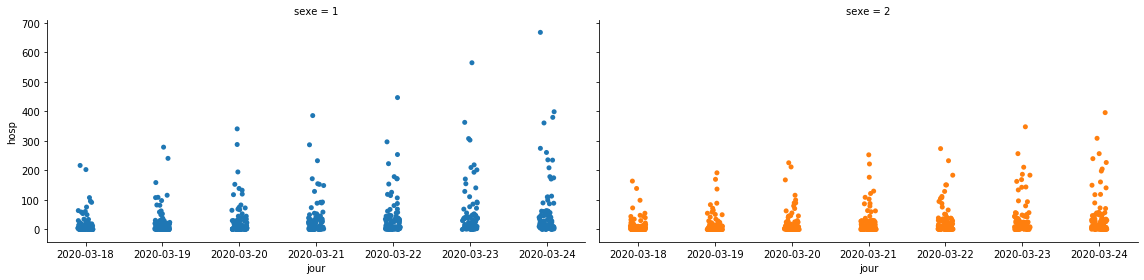

In [128]:
sns.catplot(x="jour", y="hosp", hue="sexe", data=donnees_etude[donnees_etude["sexe"]!=0], col="sexe", height=4, aspect=2)

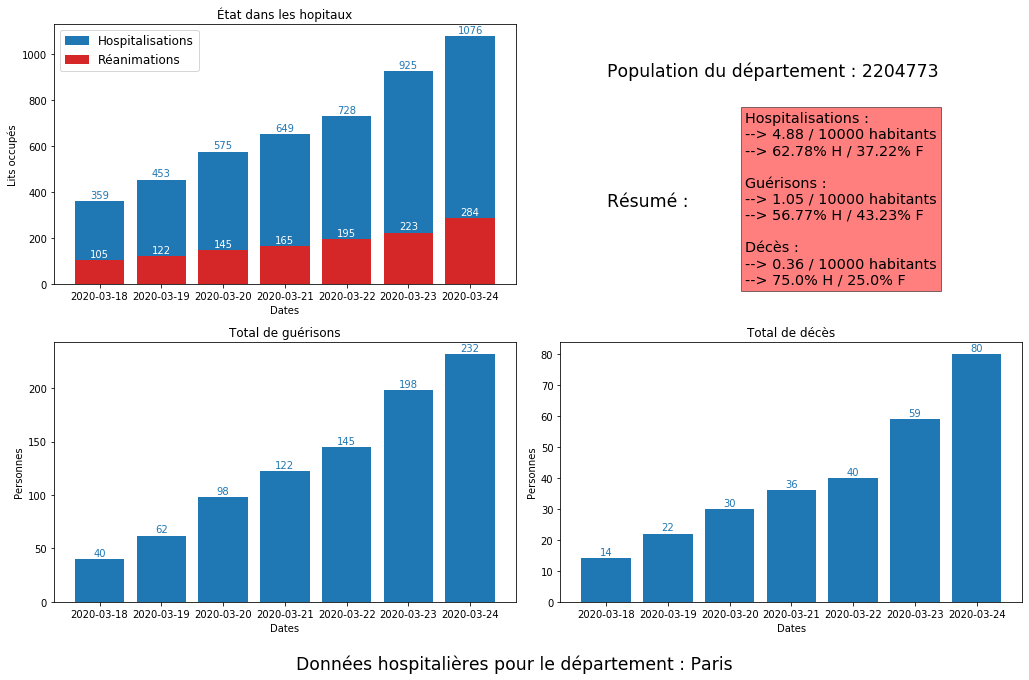

In [64]:
def autolabel(rects, axe=None, color=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axe.annotate('{0}'.format(height),
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 1),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color=color)


def afficheDepartement(idDep, etude=donnees_etude, pop=donnees_dep):
    etude = etude[etude["dep"]==str(idDep)]
    
    # Répartition Hommes / Femmes :
    etude_h = etude[etude["sexe"]==1]
    etude_f = etude[etude["sexe"]==2]
    hosp_h_f = [round(etude_h["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2),
                round(etude_f["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2)]
    rad_h_f = [round(etude_h["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2),
               round(etude_f["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2)]
    dc_h_f = [round(etude_h["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2),
              round(etude_f["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2)]
    # Total des genres (des fois supérieur à la somme H + F)
    etude = etude[etude["sexe"]==0]
    
    # Données de population
    pop = pop[pop["CODDEP"]==str(idDep)]
    nom_dep = pop["DEP"].values[0]
    pop_dep = pop["PTOT"].values[0]
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    # Sous figure 1
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("État dans les hopitaux")
    b1 = plt.bar(etude["jour"], etude["hosp"], color="C0")
    autolabel(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["jour"], etude["rea"], color="C3")
    autolabel(b2, axe=ax1, color="w")
    plt.ylabel("Lits occupés")
    plt.xlabel("Dates")
    plt.legend((b1[0], b2[0]), ('Hospitalisations', 'Réanimations'), loc="upper left", fontsize="large")

    # Sous figure 2
    ax2 = fig.add_subplot(2, 2, 2, frameon=False)
    msg  =  "Population du département : "
    msg += str(pop_dep)
    plt.text(0.1, 0.8, msg, fontsize="xx-large")
    msg = "Résumé :"
    plt.text(0.1, 0.3, msg, fontsize="xx-large")
    msg  = "Hospitalisations :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["hosp"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(hosp_h_f[0], hosp_h_f[1])
    msg += "\n\n"
    msg += "Guérisons :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["rad"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(rad_h_f[0], rad_h_f[1])
    msg += "\n\n"
    msg += "Décès :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["dc"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(dc_h_f[0], dc_h_f[1])
    plt.text(0.4, 0.0, msg, fontsize="x-large", bbox=dict(facecolor='red', alpha=0.5))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    # Sous figure 3
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Total de guérisons")
    b3 = plt.bar(etude["jour"], etude["rad"])
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b3, ax3, color="C0")

    # Sous figure 4
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Total de décès")
    b4 = plt.bar(etude["jour"], etude["dc"])
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b4, ax4, color="C0")
    
    fig.suptitle("Données hospitalières pour le département : {0}".format(nom_dep), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    plt.savefig(os.path.join(dossier_principal, "afficheDepartement"))
    
    
afficheDepartement(75)

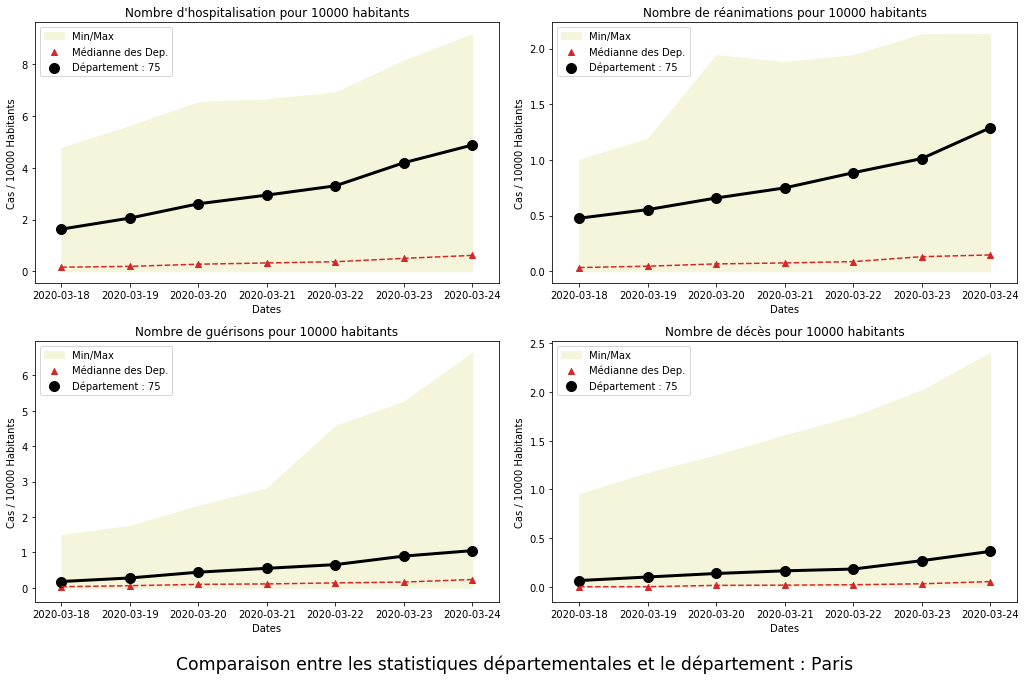

In [107]:
def f(row):
    donnee = row.values[0]
    pop    = row.values[1]
    return donnee/pop*10000


def departementVsTous(idDep, etude=donnees_etude, pop=donnees_dep):
    donnees_stat_tot = []
    donnees_stat_dep = []
    for date in etude["jour"].unique():

        donnees_pop = etude[etude["sexe"]==0]
        donnees_pop = donnees_pop[donnees_pop["jour"]==date]
        donnees_pop = donnees_pop.drop(columns=["sexe", "jour"])
        donnees_pop = donnees_pop.reset_index(drop=True)
        donnees_pop = donnees_pop.drop([100])
        if len(donnees_pop) > 100:
            donnees_pop = donnees_pop.drop([101])
        donnees_pop["pop"] = pop["PTOT"].values

        # Calcule de la part de population
        donnees_pop["stat-hosp"] = donnees_pop[["hosp", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rea"]  = donnees_pop[["rea", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rad"]  = donnees_pop[["rad", "pop"]].apply(f, axis=1)
        donnees_pop["stat-dc"]   = donnees_pop[["dc", "pop"]].apply(f, axis=1)

        # Calcule des données statistiques sur tous les départements
        donnees_stat = []
        for col in donnees_pop.columns.values.tolist():
            if "stat" in col:
                sub_stat = []
                sub_stat.append(donnees_pop[col].mean())
                sub_stat.append(donnees_pop[col].std())
                sub_stat.append(donnees_pop[col].median())
                sub_stat.append(donnees_pop[col].var())
                sub_stat.append(donnees_pop[col].min())
                sub_stat.append(donnees_pop[col].max())
                donnees_stat.append(sub_stat)
        donnees_stat_tot.append(donnees_stat)

        # Pour le département en question    
        nom_dep = pop[pop["CODDEP"]==str(idDep)]["DEP"].values[0]
        stats = ["stat-hosp", "stat-rea", "stat-rad", "stat-dc"]
        donnees_stat_dep.append([donnees_pop[donnees_pop["dep"]==str(idDep)][stat].values[0] for stat in stats])


    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    titres = ["Nombre d'hospitalisation pour 10000 habitants",
              "Nombre de réanimations pour 10000 habitants",
              "Nombre de guérisons pour 10000 habitants",
              "Nombre de décès pour 10000 habitants"]
    for k in range(len(titres)):
        # Sous figure k
        ax1 = fig.add_subplot(2, 2, k+1).set_title(titres[k])
        plt.fill_between(etude["jour"].unique(), [el[k][4] for el in donnees_stat_tot], [el[k][5] for el in donnees_stat_tot], label="Min/Max", color="beige")
#        plt.scatter(etude["jour"].unique(), [el[k][0] for el in donnees_stat_tot], c="C2", marker="*", label="Moyenne des Dep.")
#        plt.plot(etude["jour"].unique(),    [el[k][0] for el in donnees_stat_tot], c="C2", ls="--")
        plt.scatter(etude["jour"].unique(), [el[k][2] for el in donnees_stat_tot], c="C3", marker="^", label="Médianne des Dep.")
        plt.plot(etude["jour"].unique(),    [el[k][2] for el in donnees_stat_tot], c="C3", ls="--")
        plt.scatter(etude["jour"].unique(), [el[k] for el in donnees_stat_dep], c="black", s=100, label="Département : {0}".format(idDep))
        plt.plot(etude["jour"].unique(),    [el[k] for el in donnees_stat_dep], c="black", linewidth=3)
#        sns.violinplot(x="jour", y="")
        plt.legend(loc="upper left")
        plt.ylabel("Cas / 10000 Habitants")
        plt.xlabel("Dates")
    
    fig.suptitle("Comparaison entre les statistiques départementales et le département : {0}".format(nom_dep), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    plt.savefig(os.path.join(dossier_principal, "departementVsTous"))
        
departementVsTous(75)

C:\Users\alspe\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


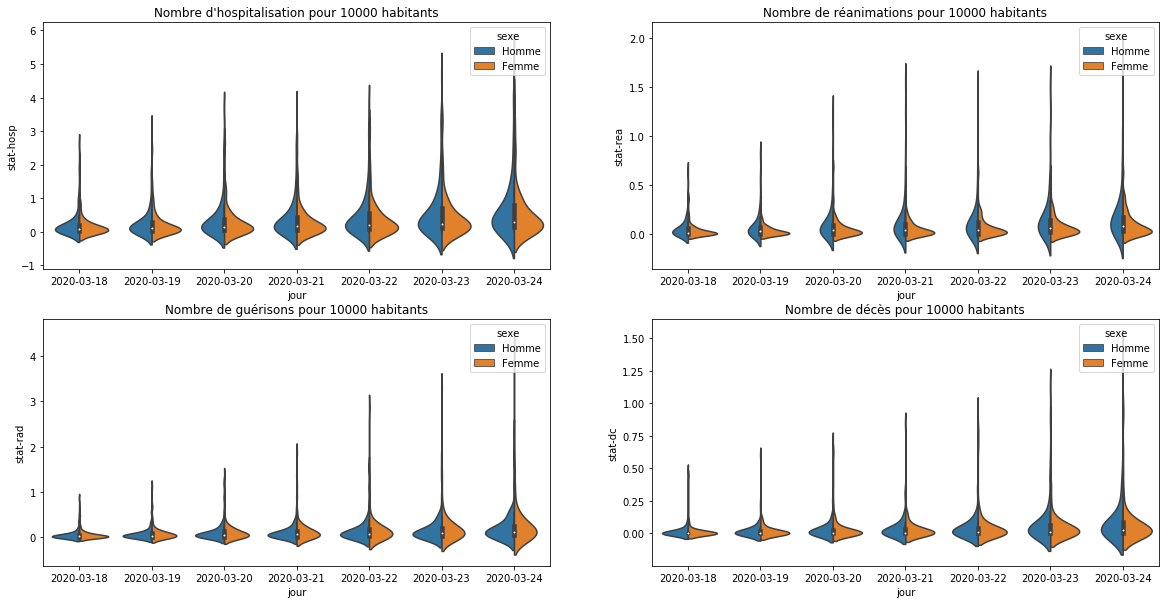

In [108]:
def changeNom(sexe):
    if sexe == 0:
        sexe = "Total"
    elif sexe == 1:
        sexe = "Homme"
    elif sexe == 2:
        sexe = "Femme"
    return sexe


donnees_pop_tot = pd.DataFrame()
for date in donnees_etude["jour"].unique():
    
    for sexe in donnees_etude["sexe"].unique()[1:]:
    
        donnees_pop = donnees_etude[donnees_etude["sexe"]==sexe]
        donnees_pop["sexe"] = donnees_pop["sexe"].apply(changeNom)
        donnees_pop = donnees_pop[donnees_pop["jour"]==date]
        donnees_pop = donnees_pop.reset_index(drop=True)
        donnees_pop = donnees_pop.drop([100])
        if len(donnees_pop) > 100:
            donnees_pop = donnees_pop.drop([101])
        donnees_pop["pop"] = donnees_dep["PTOT"].values

        # Calcule de la part de population
        donnees_pop["stat-hosp"] = donnees_pop[["hosp", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rea"]  = donnees_pop[["rea", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rad"]  = donnees_pop[["rad", "pop"]].apply(f, axis=1)
        donnees_pop["stat-dc"]   = donnees_pop[["dc", "pop"]].apply(f, axis=1)
        

        donnees_pop_tot = pd.concat([donnees_pop_tot, donnees_pop], ignore_index=True)


titres = ["Nombre d'hospitalisation pour 10000 habitants",
          "Nombre de réanimations pour 10000 habitants",
          "Nombre de guérisons pour 10000 habitants",
          "Nombre de décès pour 10000 habitants"]
stats = ["stat-hosp", "stat-rea", "stat-rad", "stat-dc"]
        
# Initialisation de la figure
fig = plt.figure(figsize=(2*10,2*5))

for k in range(len(titres)):
    ax = fig.add_subplot(2, 2, k+1)
    sns.violinplot(x="jour", y=stats[k], hue="sexe", data=donnees_pop_tot, split=True, axes=ax, kind="violin")
    ax.set_title(titres[k])

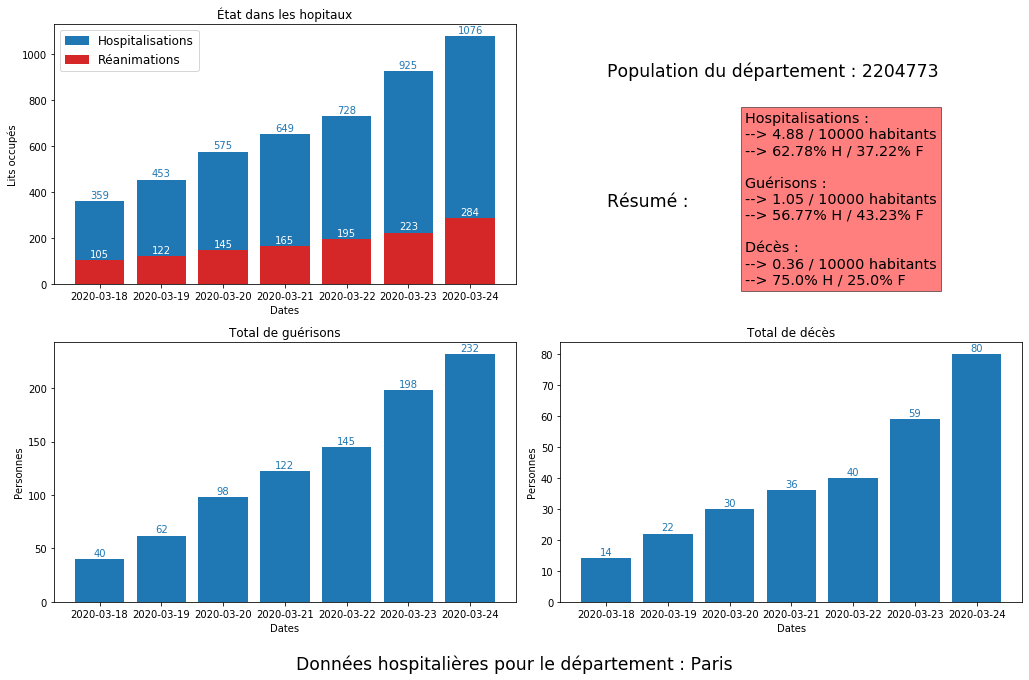

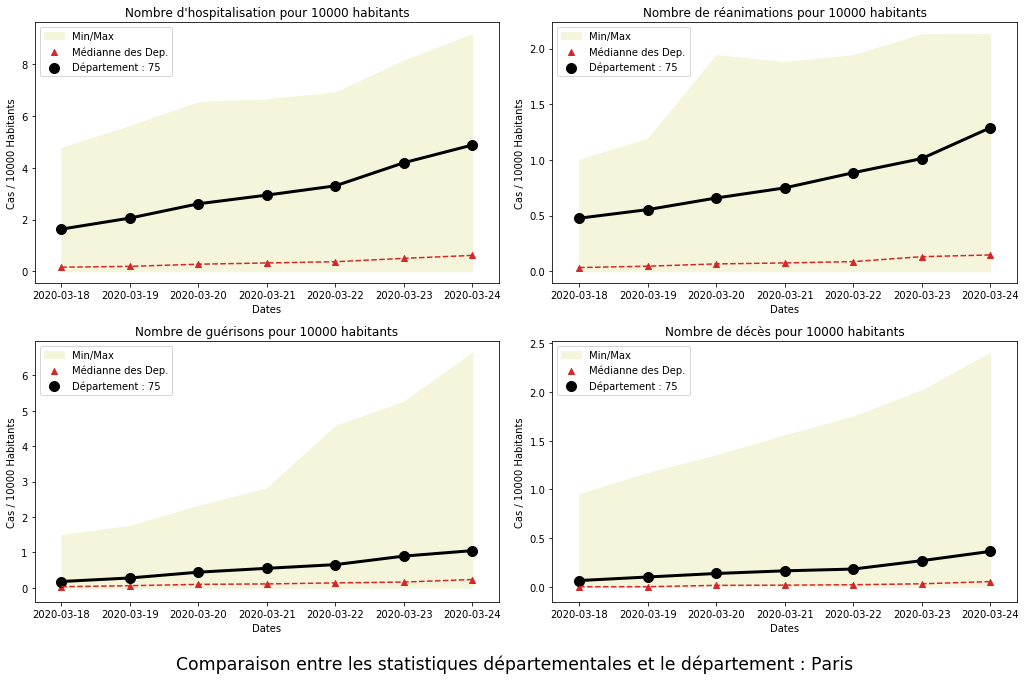

In [110]:
idDep = 75
afficheDepartement(idDep)
departementVsTous(idDep)

In [114]:
2**16

65536